In [1]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN

C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


First we should download all datasets: initial genetype df and cortical thickness, also we have these df in form splitted by 7 clusters (biclustering was performed in r)

In [2]:
genotypes = pd.read_csv("Table_genotypes_RaulVicente.csv")
genotypes_cl_1_2 = pd.read_csv("genotypes_cluster1_2.csv")
genotypes_cl_3_4 = pd.read_csv("genotypes_cluster3_4.csv")
genotypes_cl_5_6_7 = pd.read_csv("genotypes_cluster5_6_7.csv")
thickness = pd.read_csv("cortical_thickness_by_subject.csv")
thickness_cluster1 = pd.read_csv("thickness_cluster1.csv")
thickness_cluster2 = pd.read_csv("thickness_cluster2.csv")
thickness_cluster3 = pd.read_csv("thickness_cluster3.csv")
thickness_cluster4 = pd.read_csv("thickness_cluster4.csv")
thickness_cluster5 = pd.read_csv("thickness_cluster5.csv")
thickness_cluster6 = pd.read_csv("thickness_cluster6.csv")
thickness_cluster7 = pd.read_csv("thickness_cluster7.csv")

We have classification task (for 6 genes we have several values: classes)

But ML algorithms work badly with categorical value, so we should preprocess our data

In [3]:
le = preprocessing.LabelEncoder()
le.fit(genotypes.apoe)
print(list(le.classes_))
y = le.transform(genotypes_cl_1_2.apoe) 
print(y)
y = le.transform(genotypes_cl_3_4.apoe) 
print(y)
y = le.transform(genotypes_cl_5_6_7.apoe) 
print(y)

['E2/E3', 'E3/E3', 'E3/E4', 'E4/E4']
[1 1 2 1 0 0 1 1 2 1 2 1 1 1 1 3 1 1 2 1 2 2 2 1 1 2 2 1 1 1]
[1 2 1 0 1 1 1 1 1 2 1 1 1 1 2 0 1 1 1 1 1 2 1 2 1 1 2 1 1 2 1 0 1 1]
[2 0 1 0 1 1 1 1 2 1 1 0 1 1 1 1 1 2 1 1 3 1 2]


In [4]:
#first method - has the best performance
RF = RandomForestClassifier(max_depth = 5, random_state=0)

#second method = has the worst performance,  even after standartizing/scaling
RF = SGDClassifier(loss="hinge", penalty="l2")


#we will check whethe data standartization matters
#conclusion: NO
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X1 = thickness_cluster1.drop(['subject_id'], axis = 1)
scaler.fit(X1)
X_1 = scaler.transform(X1)

X2 = thickness_cluster2.drop(['subject_id'], axis = 1)
scaler.fit(X2)
X_2 = scaler.transform(X2)

X3 = pd.concat([thickness_cluster1, thickness_cluster2], axis=1, join='inner').drop(['subject_id'], axis = 1)
scaler.fit(X3)
X_3 = scaler.transform(X3)

X4 = thickness.loc[thickness['subject_id'].isin(genotypes_cl_1_2['subject_id'])].drop(['subject_id'], axis = 1)
scaler.fit(X4)
X_4 = scaler.transform(X4)

#third method, the accuracy 0.5, nothing interesting
RF = DecisionTreeClassifier(random_state=0)

In [5]:
print(X1.shape, X2.shape, X3.shape, X4.shape)

(30, 43) (30, 55) (30, 98) (30, 148)


Due to randomness we could be lucky and obtain high accuracy by chance, but it doesn't mean we actually have such a good perfomance. To resolve such a problem, we chould use cross-validation

The analysis is conducted for the first and second cluster, as they have the same rows from genotypes df

I have some intuition to check: whether the smaller number of collumns from cortical thickness for 1st or 2nd class could process better that all columns for selected rows ot join of columns from 1st and 2nd clusters

4 daatsets were constructed above

In [5]:
def first_second_biclusters(gene):    
    le = preprocessing.LabelEncoder()
    le.fit(genotypes[gene])
    y = le.transform(genotypes_cl_1_2[gene]) 
    
    scores_x1 = []
    scores_x2 = []
    scores_x3 = []
    scores_x4 = []
    
    for val in range(1, 8):
    
        RF = RandomForestClassifier(n_estimators = val, max_depth = 3)

        scores_x1.append(cross_val_score(RF, X1, y, cv=5))
        scores_x2.append(cross_val_score(RF, X2, y, cv=5))
        scores_x3.append(cross_val_score(RF, X3, y, cv=5))
        scores_x4.append(cross_val_score(RF, X4, y, cv=5))
    return scores_x1, scores_x2, scores_x3, scores_x4

In [7]:
#apoe, bin1, clu, abca7, cr1, picalm
res = first_second_biclusters('picalm')


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has 

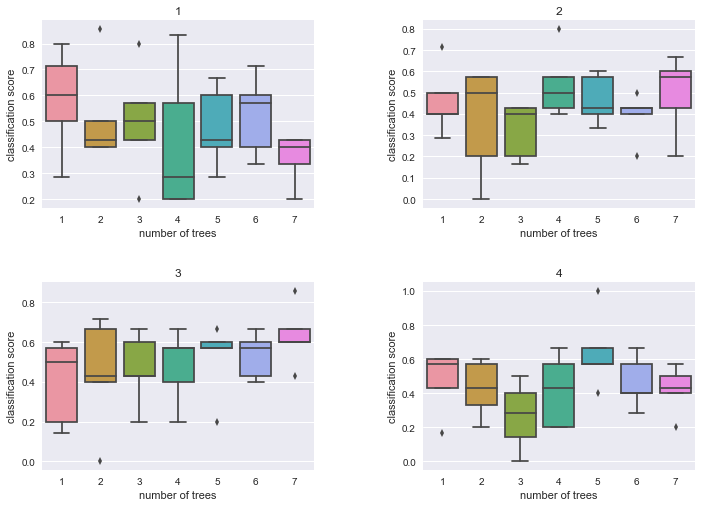

In [8]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    sns.boxplot(np.arange(7)+1, res[i-1])
    plt.title(i)
    plt.xlabel('number of trees')
    plt.ylabel('classification score')

plt.show()

Our genotype df is imbalanced and we should find some ways to deal with it 

Why is it important? - cross-validation requires the presence of each class in amount not less then number of folders

In [9]:
import collections
collections.Counter(y)

Counter({0: 3, 1: 15, 2: 4, 3: 1})

In [10]:
le = preprocessing.LabelEncoder()
full_df = pd.merge(thickness, genotypes, on='subject_id')

#changing categorical values by numeric

le.fit(full_df.apoe)
print(list(le.classes_))
full_df['apoe_coded'] = le.transform(full_df.apoe) 
collections.Counter(full_df['apoe_coded'] )

le.fit(full_df.bin1)
print(list(le.classes_))
full_df['bin1_coded'] = le.transform(full_df.bin1) 
collections.Counter(full_df['bin1_coded'] )

le.fit(full_df.clu)
print(list(le.classes_))
full_df['clu_coded'] = le.transform(full_df.clu) 
collections.Counter(full_df['clu_coded'] )

le.fit(full_df.abca7)
print(list(le.classes_))
full_df['abca7_coded'] = le.transform(full_df.abca7) 
collections.Counter(full_df['abca7_coded'] )

le.fit(full_df.cr1)
print(list(le.classes_))
full_df['cr1_coded'] = le.transform(full_df.cr1) 
collections.Counter(full_df['cr1_coded'] )

le.fit(full_df.picalm)
print(list(le.classes_))
full_df['picalm_coded'] = le.transform(full_df.picalm) 
collections.Counter(full_df['picalm_coded'] )

full_df = full_df.drop(['sex', 'age', 'apoe', 'bin1', 'clu', 'abca7', 'cr1', 'picalm'], axis = 1)

['E2/E3', 'E3/E3', 'E3/E4', 'E4/E4']
['A/A', 'A/G', 'G/G']
['C/C', 'C/T', 'T/T']
['G/G', 'G/T', 'T/T']
['A/A', 'A/G', 'G/G']
['C/C', 'C/T', 'T/T']


In [199]:
full_df.head()

,subject_id,left_G_and_S_frontomargin,left_G_and_S_occipital_inf,left_G_and_S_paracentral,left_G_and_S_subcentral,left_G_and_S_transv_frontopol,left_G_and_S_cingul-Ant,left_G_and_S_cingul-Mid-Ant,left_G_and_S_cingul-Mid-Post,left_G_cingul-Post-dorsal,...,right_S_subparietal,right_S_temporal_inf,right_S_temporal_sup,right_S_temporal_transverse,apoe_coded,bin1_coded,clu_coded,abca7_coded,cr1_coded,picalm_coded
0,s_001,1.805,1.866,1.772,2.449,1.970,2.039,2.551,2.251,2.891,...,1.952,2.442,2.065,1.399,2,1,0,2,2,1
1,s_002,2.201,2.151,1.922,2.447,2.263,2.587,2.524,2.153,2.621,...,2.167,2.541,2.399,2.713,0,1,0,2,2,2
2,s_003,2.012,1.813,1.724,2.131,2.225,2.572,2.525,2.349,2.738,...,1.873,2.254,2.180,1.865,1,1,0,1,1,1
3,s_004,2.203,1.765,2.142,2.659,2.331,2.335,2.422,2.383,2.834,...,1.987,2.418,2.404,2.451,0,1,0,2,2,1
4,s_005,2.118,2.013,1.582,2.062,2.233,2.541,2.652,2.526,2.885,...,2.333,2.864,2.273,1.779,1,1,1,2,2,0


In [11]:
from sklearn.utils import resample
# Separate majority and minority classes

In [12]:
def resampling(df):   
    df_majority = df.loc[df['apoe_coded'] == 1]
    df_minority0 = df.loc[df['apoe_coded'] == 0]
    df_minority2 = df.loc[df['apoe_coded'] == 2]
    df_minority3 = df.loc[df['apoe_coded'] == 3]


    # Upsample minority class
    df_minority_upsampled0 = resample(df_minority0, 
                                     replace=True,     # sample with replacement
                                     n_samples=df_majority.shape[0],    # to match majority class
                                     random_state=123) # reproducible results

    df_minority_upsampled2 = resample(df_minority2, 
                                     replace=True,     # sample with replacement
                                     n_samples=df_majority.shape[0],    # to match majority class
                                     random_state=123) # reproducible results

    df_minority_upsampled3 = resample(df_minority3, 
                                     replace=True,     # sample with replacement
                                     n_samples=df_majority.shape[0],    # to match majority class
                                     random_state=123) # reproducible results


    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled0, df_minority_upsampled2, df_minority_upsampled3])

    # Display new class counts
    print(collections.Counter(df.apoe_coded))
    print(collections.Counter(df_upsampled.apoe_coded))
    
    return  df_upsampled

In [13]:
df_upsampled_res = resampling(full_df)
apoe_upsampled = df_upsampled_res.copy()
apoe_upsampled.head()
apoe_full = apoe_upsampled.drop(['bin1_coded', 'clu_coded', 'abca7_coded', 'cr1_coded', 'picalm_coded'], axis = 1)

y = apoe_full

apoe_X1 = pd.DataFrame(apoe_full.loc[apoe_full['subject_id'].isin(thickness_cluster3['subject_id'])], columns=list(thickness_cluster1)).drop(['subject_id'], axis = 1)

apoe_X2 = pd.DataFrame(apoe_full.loc[apoe_full['subject_id'].isin(thickness_cluster4['subject_id'])], columns=list(thickness_cluster2)).drop(['subject_id'], axis = 1)

apoe_X3 = pd.concat([apoe_X1, apoe_X2], axis=1, join='inner')

apoe_X4 = apoe_full.loc[apoe_full['subject_id'].isin(thickness_cluster3['subject_id'])].drop(['subject_id', 'apoe_coded'], axis = 1)

y = apoe_full.loc[apoe_full['subject_id'].isin(thickness_cluster3['subject_id']), 'apoe_coded']

Counter({1: 105, 2: 35, 0: 16, 3: 3})
Counter({1: 105, 0: 105, 2: 105, 3: 105})


In [19]:
print(apoe_X1.shape, apoe_X2.shape, apoe_X3.shape, apoe_X4.shape)
print(collections.Counter(y))

(64, 43) (64, 55) (64, 98) (64, 148)
Counter({1: 24, 2: 23, 0: 17})


In [20]:
RF = RandomForestClassifier(max_depth = 5, random_state = 0)

print(np.mean(cross_val_score(RF, apoe_X1, y, cv=5)))
print(np.mean(cross_val_score(RF, apoe_X2, y, cv=5)))

print(np.mean(cross_val_score(RF, apoe_X3, y, cv=5)))
print(np.mean(cross_val_score(RF, apoe_X4, y, cv=5)))

0.8887279387279386
0.9030136530136529
0.8577755577755578
0.8372127872127872


INITIAL FULL DATASET WITHOUT USING BICLUSTERING RESULTS

UPSAMPLING AND ALL BRAIN AREAS

In [14]:
df_upsampled_res = resampling(full_df)
apoe_upsampled = df_upsampled_res.copy()
apoe_upsampled.head()
apoe_full = apoe_upsampled.drop(['bin1_coded', 'clu_coded', 'abca7_coded', 'cr1_coded', 'picalm_coded'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(apoe_full.drop(['subject_id', 'apoe_coded'], axis = 1), 
                                                    apoe_full.apoe_coded, test_size=0.3)
RF = RandomForestClassifier(max_depth = 5, random_state=0)
RF.fit(X_train, y_train)
pred = RF.predict(X_test)
print(accuracy_score(y_test, pred))
print(collections.Counter(y_test))
print(confusion_matrix(y_test, pred))
print(RF.feature_importances_)

Counter({1: 105, 2: 35, 0: 16, 3: 3})
Counter({1: 105, 0: 105, 2: 105, 3: 105})
0.7936507936507936
Counter({0: 35, 1: 33, 2: 32, 3: 26})
[[33  2  0  0]
 [ 3 14 15  1]
 [ 0  5 27  0]
 [ 0  0  0 26]]
[0.         0.         0.         0.         0.         0.
 0.01533675 0.         0.00628184 0.         0.         0.00516854
 0.00484578 0.         0.02307231 0.         0.         0.
 0.00093674 0.00483825 0.01090099 0.01559188 0.00327858 0.00133649
 0.0500072  0.01104069 0.00112589 0.00388918 0.00543327 0.
 0.02313863 0.         0.01308659 0.         0.         0.
 0.0565901  0.         0.         0.02018582 0.00309673 0.
 0.         0.         0.         0.01435234 0.         0.
 0.05739252 0.         0.00626765 0.00681603 0.01997287 0.01070172
 0.01293997 0.00556378 0.         0.01332378 0.         0.
 0.         0.         0.         0.         0.00135334 0.
 0.00843955 0.0075365  0.02037307 0.00220833 0.         0.
 0.00606013 0.         0.00783514 0.         0.         0.
 0.        

OTHER GENES

In [15]:
def resampling2(df, gene, major, minor1, minor2):   
    df_majority = df.loc[df[gene] == major]
    df_minority0 = df.loc[df[gene] == minor1]
    df_minority2 = df.loc[df[gene] == minor2]

    # Upsample minority class
    df_minority_upsampled0 = resample(df_minority0, 
                                     replace=True,     # sample with replacement
                                     n_samples=df_majority.shape[0],    # to match majority class
                                     random_state=123) # reproducible results

    df_minority_upsampled2 = resample(df_minority2, 
                                     replace=True,     # sample with replacement
                                     n_samples=df_majority.shape[0],    # to match majority class
                                     random_state=123) # reproducible results
    
    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled0, df_minority_upsampled2])

    # Display new class counts
    print(collections.Counter(df[gene]))
    print(collections.Counter(df_upsampled[gene]))
    
    return df_upsampled

In [11]:
print(collections.Counter(full_df.bin1_coded))
print(collections.Counter(full_df.clu_coded))
print(collections.Counter(full_df.abca7_coded))
print(collections.Counter(full_df.cr1_coded))
print(collections.Counter(full_df.picalm_coded))

Counter({0: 78, 1: 70, 2: 11})
Counter({1: 76, 0: 65, 2: 18})
Counter({2: 117, 1: 39, 0: 3})
Counter({2: 95, 1: 59, 0: 5})
Counter({1: 84, 0: 61, 2: 14})


In [15]:
df_upsampled_res = resampling2(full_df, 'bin1_coded', 0, 1, 2)
bin1_upsampled = df_upsampled_res.copy()
bin1_upsampled.head()
bin1_full = bin1_upsampled.drop(['apoe_coded', 'clu_coded', 'abca7_coded', 'cr1_coded', 'picalm_coded'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(bin1_full.drop(['subject_id', 'bin1_coded'], axis = 1), 
                                                    bin1_full.bin1_coded, test_size=0.3)
RF = RandomForestClassifier(max_depth = 5, random_state=0)
RF.fit(X_train, y_train)
pred = RF.predict(X_test)
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(RF.feature_importances_)

Counter({0: 78, 1: 70, 2: 11})
Counter({0: 78, 1: 78, 2: 78})
0.760563380282
[[15  3  1]
 [13 13  0]
 [ 0  0 26]]
[ 0.00333071  0.          0.01510488  0.          0.00481102  0.00467773
  0.01742802  0.0030443   0.00891371  0.          0.          0.01153826
  0.00274764  0.00384669  0.0027526   0.          0.01935505  0.00191278
  0.          0.          0.01089323  0.01355214  0.00336483  0.01129601
  0.          0.0227869   0.05056718  0.          0.00303902  0.
  0.01658163  0.          0.          0.00522893  0.00629229  0.00415443
  0.00196554  0.00298652  0.00999022  0.00205185  0.0129201   0.00168734
  0.01937598  0.0088707   0.0034922   0.00124623  0.00948283  0.01381775
  0.          0.00192818  0.          0.00181501  0.          0.          0.0019811
  0.00794968  0.01215673  0.0079501   0.          0.          0.01748111
  0.01838031  0.00682078  0.          0.          0.          0.0068551
  0.00971625  0.01322764  0.00787219  0.          0.00720709  0.00467396
  0.    

In [16]:
df_upsampled_res = resampling2(full_df, 'clu_coded', 1, 0, 2)
clu_upsampled = df_upsampled_res.copy()
clu_upsampled.head()
clu_full = clu_upsampled.drop(['apoe_coded', 'bin1_coded', 'abca7_coded', 'cr1_coded', 'picalm_coded'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(clu_full.drop(['subject_id', 'clu_coded'], axis = 1), 
                                                    clu_full.clu_coded, test_size=0.3)
RF = RandomForestClassifier(max_depth = 5, random_state=0)
RF.fit(X_train, y_train)
pred = RF.predict(X_test)
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(RF.feature_importances_)

Counter({1: 76, 0: 65, 2: 18})
Counter({1: 76, 0: 76, 2: 76})
0.623188405797
[[12  5  2]
 [ 8 12  5]
 [ 3  3 19]]
[ 0.          0.01388617  0.          0.01651031  0.02753456  0.00435837
  0.00620986  0.          0.00663955  0.          0.01711674  0.00413293
  0.          0.          0.01518176  0.00527483  0.03384723  0.00468948
  0.01056898  0.00285554  0.01389798  0.0037803   0.          0.01587148
  0.          0.00952965  0.          0.          0.          0.00679586
  0.          0.          0.          0.00315302  0.          0.
  0.02428899  0.00227829  0.02651344  0.          0.01374002  0.
  0.01705457  0.          0.          0.00926148  0.00223364  0.00225728
  0.00726018  0.          0.00704996  0.          0.00515114  0.          0.
  0.          0.          0.          0.00264931  0.          0.          0.
  0.00548089  0.00296061  0.          0.          0.00667432  0.
  0.01734389  0.00429533  0.01944216  0.00261321  0.02528772  0.00441771
  0.00160324  0.          

In [17]:
df_upsampled_res = resampling2(full_df, 'abca7_coded', 2, 1, 0)
abca7_upsampled = df_upsampled_res.copy()
abca7_upsampled.head()
abca7_full = abca7_upsampled.drop(['apoe_coded', 'bin1_coded', 'clu_coded', 'cr1_coded', 'picalm_coded'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(abca7_full.drop(['subject_id', 'abca7_coded'], axis = 1), 
                                                    abca7_full.abca7_coded, test_size=0.3)
RF = RandomForestClassifier(max_depth = 5, random_state=0)
RF.fit(X_train, y_train)
pred = RF.predict(X_test)
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(RF.feature_importances_)

Counter({2: 117, 1: 39, 0: 3})
Counter({2: 117, 1: 117, 0: 117})
0.858490566038
[[28  0  0]
 [ 0 34  5]
 [ 0 10 29]]
[ 0.00681911  0.00500759  0.00653611  0.00128514  0.          0.
  0.00350288  0.00613341  0.00320783  0.00625396  0.03781906  0.01579443
  0.0033503   0.00214105  0.0057459   0.00124523  0.00599554  0.
  0.01631947  0.          0.          0.00126965  0.00401994  0.00326554
  0.0071253   0.          0.00987645  0.          0.00644196  0.0073594
  0.01047547  0.00520605  0.0171249   0.          0.          0.00117605
  0.00123003  0.00117598  0.01655768  0.03067283  0.00409491  0.00463101
  0.00100568  0.004173    0.          0.          0.00119744  0.00397594
  0.          0.00104758  0.          0.0033928   0.          0.0012806   0.
  0.          0.          0.          0.02027211  0.          0.05334834
  0.03733767  0.0013191   0.00205262  0.01672981  0.00214314  0.00357397
  0.          0.00455561  0.00307887  0.0159163   0.04003647  0.03028606
  0.00672518  0.0083

In [18]:
df_upsampled_res = resampling2(full_df, 'cr1_coded', 2, 1, 0)
cr1_upsampled = df_upsampled_res.copy()
cr1_upsampled.head()
cr1_full = cr1_upsampled.drop(['apoe_coded', 'clu_coded', 'bin1_coded', 'abca7_coded', 'picalm_coded'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(cr1_full.drop(['subject_id', 'cr1_coded'], axis = 1), 
                                                    cr1_full.cr1_coded, test_size=0.3)
RF = RandomForestClassifier(max_depth = 5, random_state=0)
RF.fit(X_train, y_train)
pred = RF.predict(X_test)
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(RF.feature_importances_)

Counter({2: 95, 1: 59, 0: 5})
Counter({2: 95, 1: 95, 0: 95})
0.651162790698
[[25  0  0]
 [ 0  9 18]
 [ 1 11 22]]
[ 0.00295103  0.0108498   0.00653754  0.          0.          0.          0.
  0.0052833   0.02342918  0.00512455  0.03319634  0.00403314  0.00139295
  0.00267672  0.          0.01102823  0.0128405   0.00487802  0.          0.
  0.00172606  0.00133025  0.          0.          0.          0.00574013
  0.01096689  0.00148554  0.          0.          0.00533166  0.00742769
  0.08054725  0.          0.          0.00938887  0.03288946  0.
  0.01929155  0.01647976  0.          0.          0.00421556  0.00714353
  0.00621144  0.00151074  0.          0.00414275  0.0120387   0.01089549
  0.          0.0095985   0.00316798  0.          0.01165576  0.00476996
  0.          0.02070392  0.01774417  0.00146311  0.01268501  0.03336261
  0.00298123  0.          0.          0.01873245  0.02199191  0.
  0.01091356  0.00144628  0.00144025  0.          0.          0.01774064
  0.          0.004

In [14]:
df_upsampled_res = resampling2(full_df, 'picalm_coded', 1, 0, 2)
picalm_upsampled = df_upsampled_res.copy()
picalm_upsampled.head()
picalm_full = picalm_upsampled.drop(['apoe_coded', 'bin1_coded', 'clu_coded', 'abca7_coded', 'cr1_coded'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(picalm_full.drop(['subject_id', 'picalm_coded'], axis = 1), 
                                                    picalm_full.picalm_coded, test_size=0.3)
RF = RandomForestClassifier(max_depth = 5, random_state=0)
RF.fit(X_train, y_train)
pred = RF.predict(X_test)
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(RF.feature_importances_)

Counter({1: 84, 0: 61, 2: 14})
Counter({1: 84, 0: 84, 2: 84})
0.7236842105263158
[[18  7  0]
 [ 9 11  3]
 [ 2  0 26]]
[0.0066179  0.00363511 0.0097116  0.00838649 0.00771293 0.01257494
 0.01093427 0.01893814 0.00759226 0.02114734 0.01724848 0.00386366
 0.         0.         0.00603537 0.00982689 0.         0.00193108
 0.00331452 0.0045099  0.         0.         0.00133507 0.
 0.         0.         0.02008535 0.         0.         0.00936776
 0.01536008 0.02170109 0.01072171 0.00746612 0.         0.00247316
 0.00915155 0.         0.00198742 0.         0.         0.0018848
 0.00455239 0.02994365 0.         0.00341588 0.         0.01342671
 0.00178539 0.         0.         0.02165375 0.         0.00947628
 0.02833542 0.00587652 0.00612919 0.00798555 0.         0.
 0.00804039 0.00581794 0.         0.         0.         0.
 0.01999695 0.00248024 0.01145212 0.0346734  0.         0.00620111
 0.01269728 0.         0.00425176 0.00442718 0.01840528 0.
 0.         0.         0.04893141 0.01344675

But maybe resampling in this case is made not correctly


Because it its posible situation when after split the same rows can apeare both in train and test dataset


Tha next analysis was inspired by this article

http://bigdata-madesimple.com/dealing-with-unbalanced-class-svm-random-forest-and-decision-tree-in-python/

In [20]:
full_df.head()

,subject_id,left_G_and_S_frontomargin,left_G_and_S_occipital_inf,left_G_and_S_paracentral,left_G_and_S_subcentral,left_G_and_S_transv_frontopol,left_G_and_S_cingul.Ant,left_G_and_S_cingul.Mid.Ant,left_G_and_S_cingul.Mid.Post,left_G_cingul.Post.dorsal,...,right_S_subparietal,right_S_temporal_inf,right_S_temporal_sup,right_S_temporal_transverse,apoe_coded,bin1_coded,clu_coded,abca7_coded,cr1_coded,picalm_coded
0,s_001,1.805,1.866,1.772,2.449,1.970,2.039,2.551,2.251,2.891,...,1.952,2.442,2.065,1.399,2,1,0,2,2,1
1,s_002,2.201,2.151,1.922,2.447,2.263,2.587,2.524,2.153,2.621,...,2.167,2.541,2.399,2.713,0,1,0,2,2,2
2,s_003,2.012,1.813,1.724,2.131,2.225,2.572,2.525,2.349,2.738,...,1.873,2.254,2.180,1.865,1,1,0,1,1,1
3,s_004,2.203,1.765,2.142,2.659,2.331,2.335,2.422,2.383,2.834,...,1.987,2.418,2.404,2.451,0,1,0,2,2,1
4,s_005,2.118,2.013,1.582,2.062,2.233,2.541,2.652,2.526,2.885,...,2.333,2.864,2.273,1.779,1,1,1,2,2,0


In [22]:
scores = []

for val in range(1, 41):
    RF = RandomForestClassifier(n_estimators = val)
    validated = cross_val_score(RF, full_df.drop(['subject_id', 'apoe_coded', 'bin1_coded', 'clu_coded', 'abca7_coded', 'cr1_coded', 
                                       'picalm_coded'], axis = 1), full_df.apoe_coded, cv = 5)
    scores.append(validated)


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has 

C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has 

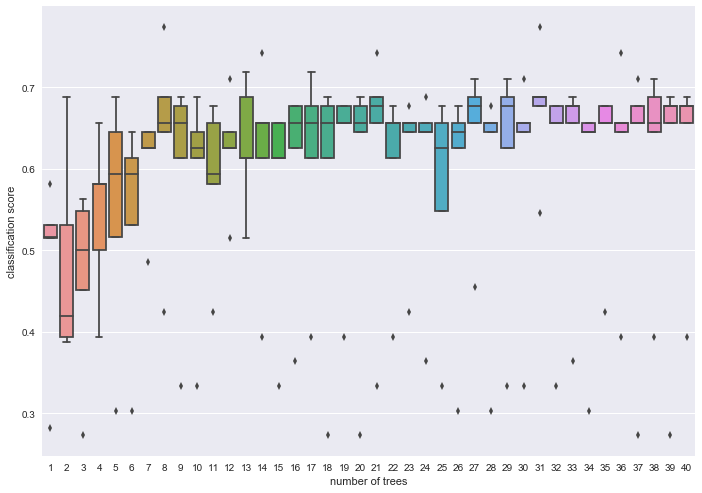

In [23]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(np.arange(40)+1, scores)
plt.xlabel('number of trees')
plt.ylabel('classification score')
plt.show()

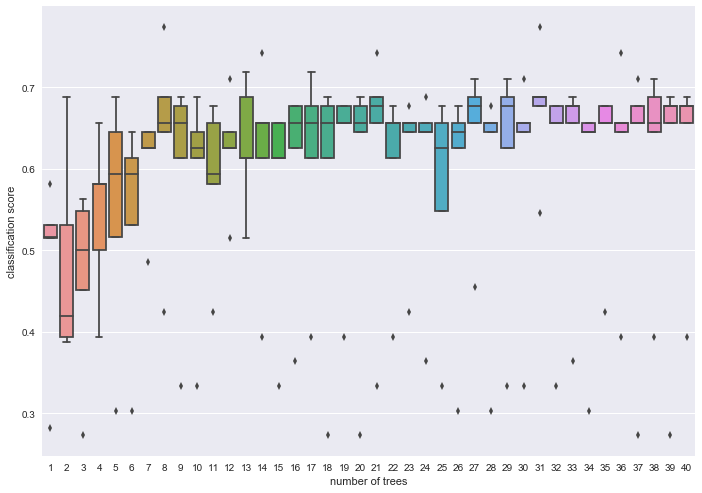

In [24]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(np.arange(40)+1, scores)
plt.xlabel('number of trees')
plt.ylabel('classification score')
plt.show()

Perfect number of trees is 6 ??

In [12]:
full_df.shape

(159, 155)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(full_df.drop(['subject_id', 'apoe_coded', 'bin1_coded', 'clu_coded', 'abca7_coded', 'cr1_coded', 
                                       'picalm_coded'], axis = 1), full_df.apoe_coded, test_size=0.2)
RF = RandomForestClassifier(n_estimators = 7)
RF.fit(X_train, y_train)
pred = RF.predict(X_test)
print(accuracy_score(pred, y_test))
print(confusion_matrix(y_test, pred))

#RF.predict_proba(X_test)
x_tr, x_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1)

0.53125
[[ 0  2  1  0]
 [ 0 17  2  0]
 [ 0  9  0  0]
 [ 0  1  0  0]]


In [49]:
sorted(collections.Counter(full_df.picalm_coded).items())

[(0, 61), (1, 84), (2, 14)]

In [52]:
X_resampled_adasyn, y_resampled_adasyn = ADASYN(n_neighbors=1).fit_sample(x_tr, y_tr)
print(sorted(collections.Counter(y_resampled_adasyn).items()))
X_resampled, y_resampled = SMOTE(k_neighbors=1).fit_sample(x_tr, y_tr)
print(sorted(collections.Counter(y_resampled).items()))

RF = RandomForestClassifier(n_estimators = 5)
RF.fit(X_resampled, y_resampled)
pred = RF.predict(x_val)
print(accuracy_score(pred, y_val))
print(f1_score(pred, y_val, average = 'micro'))
print(f1_score(pred, y_val, average = 'macro'))
print(f1_score(pred, y_val, average = 'weighted'))
print(confusion_matrix(y_val, pred))

pred = RF.predict(X_test)
print(accuracy_score(pred, y_test))
print(f1_score(pred, y_test, average = 'micro'))
print(f1_score(pred, y_test, average = 'macro'))
print(f1_score(pred, y_test, average = 'weighted'))
print(confusion_matrix(y_test, pred))


scores = []

RF = RandomForestClassifier(n_estimators = 5)

#initial dataset , apoe, [(0, 16), (1, 105), (2, 35), (3, 3)]
scores.append(cross_val_score(RF, full_df.drop(['subject_id', 'apoe_coded', 'bin1_coded', 'clu_coded', 'abca7_coded', 'cr1_coded',  'picalm_coded'], axis = 1), full_df.apoe_coded, cv = 10, scoring='f1_macro'))

#resampling, repeating existing rows, [(0, 105), (1, 105), (2, 105), (3, 105)]
scores.append(cross_val_score(RF, apoe_full.drop(['subject_id', 'apoe_coded'], axis = 1), apoe_full.apoe_coded , cv = 10, scoring='f1_macro'))

#oversampling, SMOTE tehcnique [(0, 105), (1, 105), (2, 105), (3, 105)]
scores.append(cross_val_score(RF, X_resampled, y_resampled, cv = 10, scoring='f1_macro'))

#oversampling, ADASYN tehcnique [(0, 100), (1, 105), (2, 91), (3, 105)]
scores.append(cross_val_score(RF, X_resampled_adasyn, y_resampled_adasyn, cv = 10, scoring='f1_macro'))

RF = RandomForestClassifier(n_estimators = 5, class_weight = "balanced")
#initial dataset , apoe, [(0, 16), (1, 105), (2, 35), (3, 3)]
scores.append(cross_val_score(RF, full_df.drop(['subject_id', 'apoe_coded', 'bin1_coded', 'clu_coded', 'abca7_coded', 'cr1_coded',  'picalm_coded'], axis = 1), full_df.apoe_coded, cv = 10, scoring='f1_macro'))


[(0, 81), (1, 83), (2, 78), (3, 82)]
[(0, 83), (1, 83), (2, 83), (3, 83)]
0.07692307692307693
0.07692307692307693
0.041666666666666664
0.10256410256410256
[[0 2 0 0]
 [3 1 0 0]
 [0 5 0 1]
 [1 0 0 0]]
0.46875
0.46875
0.2698412698412698
0.5133928571428571
[[ 0  3  0]
 [ 2 14  2]
 [ 3  7  1]]


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average,

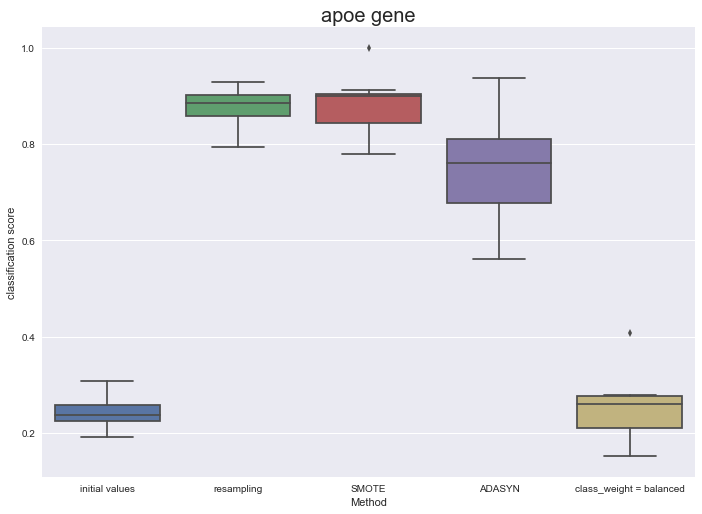

In [53]:
#APOE
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(['initial values', 'resampling', 'SMOTE', "ADASYN", "RF with class_weight = balanced"], scores)
plt.xlabel('Method')
plt.ylabel('classification score')
plt.title('apoe gene', fontsize=20)
plt.show()

In [27]:
X_resampled_adasyn, y_resampled_adasyn = ADASYN(n_neighbors=1).fit_sample(x_tr, y_tr)
print(sorted(collections.Counter(y_resampled_adasyn).items()))
X_resampled, y_resampled = SMOTE(k_neighbors=1).fit_sample(x_tr, y_tr)
print(sorted(collections.Counter(y_resampled).items()))

RF = RandomForestClassifier(n_estimators = 5)
RF.fit(X_resampled, y_resampled)
pred = RF.predict(x_val)
print(accuracy_score(pred, y_val))
print(f1_score(pred, y_val, average = 'micro'))
print(f1_score(pred, y_val, average = 'macro'))
print(f1_score(pred, y_val, average = 'weighted'))
print(confusion_matrix(y_val, pred))

pred = RF.predict(X_test)
print(accuracy_score(pred, y_test))
print(f1_score(pred, y_test, average = 'micro'))
print(f1_score(pred, y_test, average = 'macro'))
print(f1_score(pred, y_test, average = 'weighted'))
print(confusion_matrix(y_test, pred))


scores = []

RF = RandomForestClassifier(n_estimators = 5)

#initial dataset
scores.append(cross_val_score(RF, full_df.drop(['subject_id', 'apoe_coded', 'bin1_coded', 'clu_coded', 'abca7_coded', 'cr1_coded',  'picalm_coded'], axis = 1), full_df.picalm_coded, cv = 10, scoring='f1_macro'))

#resampling
scores.append(cross_val_score(RF, picalm_full.drop(['subject_id', 'picalm_coded'], axis = 1), picalm_full.picalm_coded , cv = 10, scoring='f1_macro'))

#oversampling, SMOTE tehcnique 
scores.append(cross_val_score(RF, X_resampled, y_resampled, cv = 10, scoring='f1_macro'))

#oversampling, ADASYN tehcnique 
scores.append(cross_val_score(RF, X_resampled_adasyn, y_resampled_adasyn, cv = 10, scoring='f1_macro'))


[(0, 68), (1, 61), (2, 62)]
[(0, 61), (1, 61), (2, 61)]
0.23076923076923078
0.23076923076923078
0.13333333333333333
0.24615384615384614
[[0 4 1]
 [4 3 0]
 [0 1 0]]
0.53125
0.53125
0.3703703703703704
0.5069444444444444
[[11  2  3]
 [ 9  6  1]
 [ 0  0  0]]


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaco

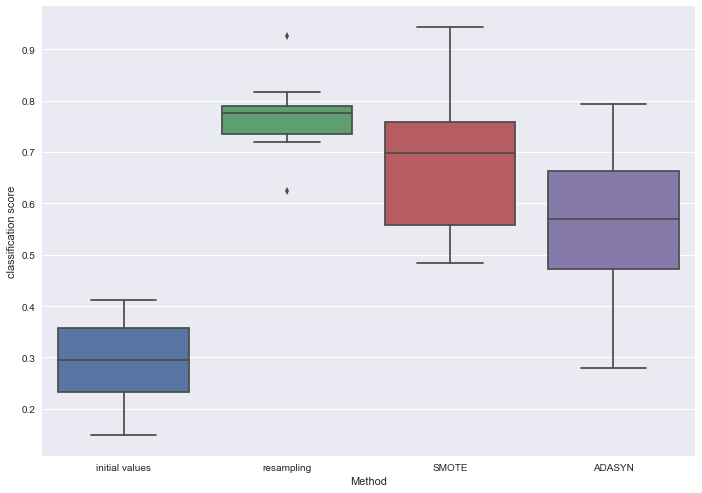

In [28]:
#PICALM
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(['initial values', 'resampling', 'SMOTE', "ADASYN"], scores)
plt.xlabel('Method')
plt.ylabel('classification score')
plt.show()

When upsampling using SMOTE, I don’t create duplicate observations. However, because the SMOTE algorithm uses the nearest neighbors of observations to create synthetic data, it still bleeds information. If the nearest neighbors of minority class observations in the training set end up in the validation set, their information is partially captured by the synthetic data in the training set. Since I’m splitting the data randomly, we’d expect to have this happen. As a result, the model will be better able to predict validation set values than completely new data.



CORRECT WORK WITH RESAMPLING TECHIQUE

In [16]:
genotypes = pd.read_csv("Table_genotypes_full.csv")
thickness = pd.read_csv("cortical_thickness_by_subject_full.csv")
full_df = pd.merge(thickness, genotypes, on='subject_id')

#changing categorical values by numeric
le = preprocessing.LabelEncoder()
le.fit(full_df.apoe)
print(list(le.classes_))
full_df['apoe_coded'] = le.transform(full_df.apoe) 
collections.Counter(full_df['apoe_coded'] )

le.fit(full_df.bin1)
print(list(le.classes_))
full_df['bin1_coded'] = le.transform(full_df.bin1) 
collections.Counter(full_df['bin1_coded'] )

le.fit(full_df.clu)
print(list(le.classes_))
full_df['clu_coded'] = le.transform(full_df.clu) 
collections.Counter(full_df['clu_coded'] )

le.fit(full_df.abca7)
print(list(le.classes_))
full_df['abca7_coded'] = le.transform(full_df.abca7) 
collections.Counter(full_df['abca7_coded'] )

le.fit(full_df.cr1)
print(list(le.classes_))
full_df['cr1_coded'] = le.transform(full_df.cr1) 
collections.Counter(full_df['cr1_coded'] )

le.fit(full_df.picalm)
print(list(le.classes_))
full_df['picalm_coded'] = le.transform(full_df.picalm) 
collections.Counter(full_df['picalm_coded'] )

full_df = full_df.drop(['sex', 'age', 'apoe', 'bin1', 'clu', 'abca7', 'cr1', 'picalm'], axis = 1)
full_df = full_df.dropna()

['E2E3', 'E3E3', 'E3E4', 'E4E4']
['AA', 'AG', 'GG']
['CC', 'CT', 'TT']
['GG', 'GT', 'TT']
['AA', 'AG', 'GG']
['CC', 'CT', 'TT']


In [76]:
scores_adasyn = []
scores_smote = []
scores_resampled = []
scores_initial = []
scores_RF_updated = []

f_i_adasyn = []
f_i_smote = []
f_i_resampled = []
f_i_initial = []
f_i_RF_updated = []

for i in range(1000):
    x_tr, x_val, y_tr, y_val = train_test_split(full_df.drop(['subject_id', 'apoe_coded', 'bin1_coded', 'clu_coded', 'abca7_coded', 'cr1_coded', 
                                           'picalm_coded'], axis = 1), full_df.apoe_coded, test_size=0.2)

    X_resampled_adasyn, y_resampled_adasyn = ADASYN(n_neighbors=1).fit_sample(x_tr, y_tr)
    X_resampled_smote, y_resampled_smote = SMOTE(k_neighbors=1).fit_sample(x_tr, y_tr)
    df_upsampled_res = resampling(pd.concat([x_tr, y_tr], axis=1))
    X_resampled, y_resampled = df_upsampled_res.drop(['apoe_coded'], axis = 1), df_upsampled_res.apoe_coded
    
    RF = RandomForestClassifier(n_estimators = 11)
    RF.fit(X_resampled_adasyn, y_resampled_adasyn)
    pred = RF.predict(x_val)
    scores_adasyn.append(f1_score(pred, y_val, average = 'weighted'))
    f_i_adasyn.append(RF.feature_importances_)


    RF.fit(X_resampled_smote, y_resampled_smote)
    pred = RF.predict(x_val)
    scores_smote.append(f1_score(pred, y_val, average = 'weighted'))
    f_i_smote.append(RF.feature_importances_)

    RF.fit(X_resampled, y_resampled)
    pred = RF.predict(x_val)
    scores_resampled.append(f1_score(pred, y_val, average = 'weighted'))
    f_i_resampled.append(RF.feature_importances_)

    RF.fit(x_tr, y_tr)
    pred = RF.predict(x_val)
    scores_initial.append(f1_score(pred, y_val, average = 'weighted'))
    f_i_initial.append(RF.feature_importances_)

    RF = RandomForestClassifier(n_estimators =11, class_weight = "balanced")
    RF.fit(x_tr, y_tr)
    pred = RF.predict(x_val)
    scores_RF_updated.append(f1_score(pred, y_val, average = 'weighted'))
    f_i_RF_updated.append(RF.feature_importances_)


Counter({1: 132, 2: 43, 0: 17, 3: 2})
Counter({1: 132, 0: 132, 2: 132, 3: 132})
Counter({1: 131, 2: 39, 0: 21, 3: 3})
Counter({1: 131, 0: 131, 2: 131, 3: 131})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\cla

Counter({1: 131, 2: 42, 0: 18, 3: 3})
Counter({1: 131, 0: 131, 2: 131, 3: 131})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Counter({1: 132, 2: 38, 0: 22, 3: 2})
Counter({1: 132, 0: 132, 2: 132, 3: 132})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Counter({1: 129, 2: 43, 0: 18, 3: 4})
Counter({1: 129, 0: 129, 2: 129, 3: 129})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Counter({1: 124, 2: 46, 0: 21, 3: 3})
Counter({1: 124, 0: 124, 2: 124, 3: 124})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\cla

Counter({1: 126, 2: 45, 0: 19, 3: 4})
Counter({1: 126, 0: 126, 2: 126, 3: 126})
Counter({1: 130, 2: 42, 0: 18, 3: 4})
Counter({1: 130, 0: 130, 2: 130, 3: 130})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py3

Counter({1: 130, 2: 42, 0: 19, 3: 3})
Counter({1: 130, 0: 130, 2: 130, 3: 130})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Counter({1: 132, 2: 40, 0: 18, 3: 4})
Counter({1: 132, 0: 132, 2: 132, 3: 132})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Counter({1: 134, 2: 34, 0: 23, 3: 3})
Counter({1: 134, 0: 134, 2: 134, 3: 134})
Counter({1: 131, 2: 38, 0: 22, 3: 3})
Counter({1: 131, 0: 131, 2: 131, 3: 131})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\cla

Counter({1: 131, 2: 40, 0: 19, 3: 4})
Counter({1: 131, 0: 131, 2: 131, 3: 131})
Counter({1: 131, 2: 40, 0: 19, 3: 4})
Counter({1: 131, 0: 131, 2: 131, 3: 131})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Counter({1: 124, 2: 44, 0: 22, 3: 4})
Counter({1: 124, 0: 124, 2: 124, 3: 124})
Counter({1: 126, 2: 41, 0: 23, 3: 4})
Counter({1: 126, 0: 126, 2: 126, 3: 126})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Counter({1: 126, 2: 42, 0: 22, 3: 4})
Counter({1: 126, 0: 126, 2: 126, 3: 126})
Counter({1: 131, 2: 42, 0: 17, 3: 4})
Counter({1: 131, 0: 131, 2: 131, 3: 131})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Counter({1: 130, 2: 42, 0: 19, 3: 3})
Counter({1: 130, 0: 130, 2: 130, 3: 130})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\cla

Counter({1: 129, 2: 40, 0: 21, 3: 4})
Counter({1: 129, 0: 129, 2: 129, 3: 129})
Counter({1: 128, 2: 41, 0: 21, 3: 4})
Counter({1: 128, 0: 128, 2: 128, 3: 128})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Counter({1: 123, 2: 48, 0: 21, 3: 2})
Counter({1: 123, 0: 123, 2: 123, 3: 123})
Counter({1: 129, 2: 42, 0: 21, 3: 2})
Counter({1: 129, 0: 129, 2: 129, 3: 129})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\cla

Counter({1: 124, 2: 47, 0: 19, 3: 4})
Counter({1: 124, 0: 124, 2: 124, 3: 124})
Counter({1: 126, 2: 43, 0: 21, 3: 4})
Counter({1: 126, 0: 126, 2: 126, 3: 126})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Counter({1: 131, 2: 39, 0: 21, 3: 3})
Counter({1: 131, 0: 131, 2: 131, 3: 131})
Counter({1: 126, 2: 44, 0: 20, 3: 4})
Counter({1: 126, 0: 126, 2: 126, 3: 126})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\cla

Counter({1: 126, 2: 46, 0: 19, 3: 3})
Counter({1: 126, 0: 126, 2: 126, 3: 126})
Counter({1: 127, 2: 46, 0: 17, 3: 4})
Counter({1: 127, 0: 127, 2: 127, 3: 127})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\cla

Counter({1: 126, 2: 45, 0: 19, 3: 4})
Counter({1: 126, 0: 126, 2: 126, 3: 126})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Counter({1: 126, 2: 45, 0: 19, 3: 4})
Counter({1: 126, 0: 126, 2: 126, 3: 126})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 1, n_neighbors = 2

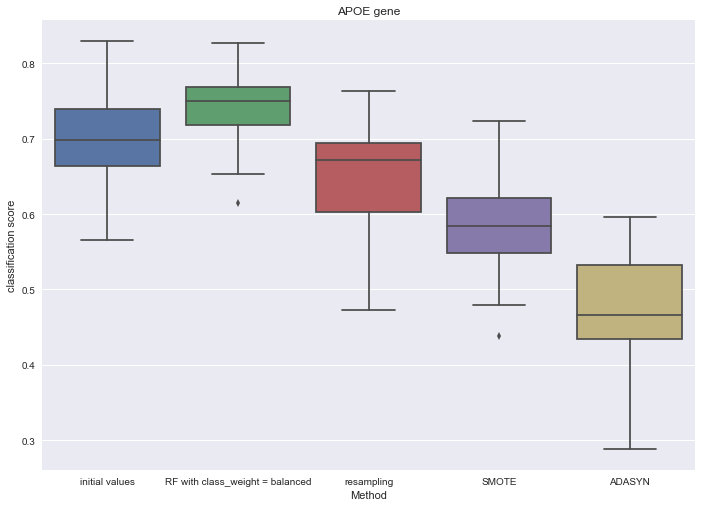

In [77]:
scores = [scores_initial, scores_RF_updated, scores_resampled, scores_smote, scores_adasyn]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(['initial values', 'RF with class_weight = balanced', 'resampling', 'SMOTE', 'ADASYN'], scores)
plt.xlabel('Method')
plt.ylabel('classification score')
plt.title('APOE gene')
plt.savefig('foo.png')
plt.show()

In [51]:
pd.DataFrame(f_i_adasyn).to_csv("f_i_adasyn.csv")
pd.DataFrame(f_i_smote).to_csv("f_i_smote.csv")
pd.DataFrame(f_i_resampled).to_csv("f_i_resampled.csv")
pd.DataFrame(f_i_initial).to_csv("f_i_initial.csv")
pd.DataFrame(f_i_RF_updated).to_csv("f_i_RF_updated.csv")

top 5 feature importance

In [24]:
full_df.columns[[16, 32, 30, 59, 39]]

Index(['left_G_front_sup', 'left_G_subcallosal', 'left_G_precuneus',
       'left_S_occipital_ant', 'left_Lat_Fis.ant.Horizont'],
      dtype='object')

Single brain area instead of all 148 

In [17]:
single = full_df[['left_G_front_sup','left_G_subcallosal', 'apoe_coded']]

In [22]:
scores_adasyn = []
scores_smote = []
scores_resampled = []
scores_initial = []
scores_RF_updated = []

f_i_adasyn = []
f_i_smote = []
f_i_resampled = []
f_i_initial = []
f_i_RF_updated = []

for i in range(1000):
    x_tr, x_val, y_tr, y_val = train_test_split(single[['left_G_front_sup','left_G_subcallosal']], single.apoe_coded, test_size=0.2)

    X_resampled_adasyn, y_resampled_adasyn = ADASYN(n_neighbors=1).fit_sample(x_tr, y_tr)
    X_resampled_smote, y_resampled_smote = SMOTE(k_neighbors=1).fit_sample(x_tr, y_tr)
    df_upsampled_res = resampling(pd.concat([x_tr, y_tr], axis=1))
    X_resampled, y_resampled = df_upsampled_res.drop(['apoe_coded'], axis = 1), df_upsampled_res.apoe_coded
    
    RF = RandomForestClassifier(n_estimators = 11)
    RF.fit(X_resampled_adasyn, y_resampled_adasyn)
    pred = RF.predict(x_val)
    scores_adasyn.append(f1_score(pred, y_val, average = 'weighted'))
    f_i_adasyn.append(RF.feature_importances_)


    RF.fit(X_resampled_smote, y_resampled_smote)
    pred = RF.predict(x_val)
    scores_smote.append(f1_score(pred, y_val, average = 'weighted'))
    f_i_smote.append(RF.feature_importances_)

    RF.fit(X_resampled, y_resampled)
    pred = RF.predict(x_val)
    scores_resampled.append(f1_score(pred, y_val, average = 'weighted'))
    f_i_resampled.append(RF.feature_importances_)

    RF.fit(x_tr, y_tr)
    pred = RF.predict(x_val)
    scores_initial.append(f1_score(pred, y_val, average = 'weighted'))
    f_i_initial.append(RF.feature_importances_)

    RF = RandomForestClassifier(n_estimators =11, class_weight = "balanced")
    RF.fit(x_tr, y_tr)
    pred = RF.predict(x_val)
    scores_RF_updated.append(f1_score(pred, y_val, average = 'weighted'))
    f_i_RF_updated.append(RF.feature_importances_)


Counter({1: 122, 2: 47, 0: 21, 3: 4})
Counter({1: 122, 0: 122, 2: 122, 3: 122})
Counter({1: 128, 2: 42, 0: 20, 3: 4})
Counter({1: 128, 0: 128, 2: 128, 3: 128})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaco

Counter({1: 123, 2: 48, 0: 20, 3: 3})
Counter({1: 123, 0: 123, 2: 123, 3: 123})
Counter({1: 129, 2: 43, 0: 20, 3: 2})
Counter({1: 129, 0: 129, 2: 129, 3: 129})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\cla

Counter({1: 131, 2: 42, 0: 19, 3: 2})
Counter({1: 131, 0: 131, 2: 131, 3: 131})
Counter({1: 127, 2: 43, 0: 20, 3: 4})
Counter({1: 127, 0: 127, 2: 127, 3: 127})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Counter({1: 135, 2: 41, 0: 14, 3: 4})
Counter({1: 135, 0: 135, 2: 135, 3: 135})
Counter({1: 123, 2: 46, 0: 21, 3: 4})
Counter({1: 123, 0: 123, 2: 123, 3: 123})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py3

Counter({1: 128, 2: 39, 0: 24, 3: 3})
Counter({1: 128, 0: 128, 2: 128, 3: 128})
Counter({1: 127, 2: 44, 0: 19, 3: 4})
Counter({1: 127, 0: 127, 2: 127, 3: 127})
Counter({1: 129, 2: 43, 0: 18, 3: 4})
Counter({1: 129, 0: 129, 2: 129, 3: 129})
Counter({1: 127, 2: 43, 0: 20, 3: 4})
Counter({1: 127, 0: 127, 2: 127, 3: 127})
Counter({1: 128, 2: 41, 0: 21, 3: 4})
Counter({1: 128, 0: 128, 2: 128, 3: 128})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaco

Counter({1: 132, 2: 39, 0: 19, 3: 4})
Counter({1: 132, 0: 132, 2: 132, 3: 132})
Counter({1: 124, 2: 46, 0: 21, 3: 3})
Counter({1: 124, 0: 124, 2: 124, 3: 124})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\cla

Counter({1: 128, 2: 41, 0: 22, 3: 3})
Counter({1: 128, 0: 128, 2: 128, 3: 128})
Counter({1: 126, 2: 43, 0: 22, 3: 3})
Counter({1: 126, 0: 126, 2: 126, 3: 126})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-pa

Counter({1: 128, 2: 41, 0: 21, 3: 4})
Counter({1: 128, 0: 128, 2: 128, 3: 128})
Counter({1: 129, 2: 41, 0: 21, 3: 3})
Counter({1: 129, 0: 129, 2: 129, 3: 129})
Counter({1: 130, 2: 43, 0: 18, 3: 3})
Counter({1: 130, 0: 130, 2: 130, 3: 130})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\cla

Counter({1: 129, 2: 42, 0: 21, 3: 2})
Counter({1: 129, 0: 129, 2: 129, 3: 129})
Counter({1: 125, 2: 46, 0: 21, 3: 2})
Counter({1: 125, 0: 125, 2: 125, 3: 125})
Counter({1: 129, 2: 43, 0: 19, 3: 3})
Counter({1: 129, 0: 129, 2: 129, 3: 129})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\cla

Counter({1: 127, 2: 43, 0: 20, 3: 4})
Counter({1: 127, 0: 127, 2: 127, 3: 127})
Counter({1: 122, 2: 45, 0: 24, 3: 3})
Counter({1: 122, 0: 122, 2: 122, 3: 122})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Counter({1: 124, 2: 47, 0: 20, 3: 3})
Counter({1: 124, 0: 124, 2: 124, 3: 124})
Counter({1: 132, 2: 41, 0: 18, 3: 3})
Counter({1: 132, 0: 132, 2: 132, 3: 132})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\cla

Counter({1: 128, 2: 40, 0: 23, 3: 3})
Counter({1: 128, 0: 128, 2: 128, 3: 128})
Counter({1: 130, 2: 45, 0: 17, 3: 2})
Counter({1: 130, 0: 130, 2: 130, 3: 130})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-pa

Counter({1: 127, 2: 42, 0: 21, 3: 4})
Counter({1: 127, 0: 127, 2: 127, 3: 127})
Counter({1: 128, 2: 44, 0: 18, 3: 4})
Counter({1: 128, 0: 128, 2: 128, 3: 128})
Counter({1: 126, 2: 44, 0: 21, 3: 3})
Counter({1: 126, 0: 126, 2: 126, 3: 126})
Counter({1: 131, 2: 41, 0: 18, 3: 4})
Counter({1: 131, 0: 131, 2: 131, 3: 131})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklear

Counter({1: 127, 2: 43, 0: 21, 3: 3})
Counter({1: 127, 0: 127, 2: 127, 3: 127})
Counter({1: 129, 2: 42, 0: 19, 3: 4})
Counter({1: 129, 0: 129, 2: 129, 3: 129})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Counter({1: 128, 2: 45, 0: 18, 3: 3})
Counter({1: 128, 0: 128, 2: 128, 3: 128})
Counter({1: 132, 2: 41, 0: 17, 3: 4})
Counter({1: 132, 0: 132, 2: 132, 3: 132})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-pa

Counter({1: 126, 2: 44, 0: 20, 3: 4})
Counter({1: 126, 0: 126, 2: 126, 3: 126})
Counter({1: 129, 2: 39, 0: 23, 3: 3})
Counter({1: 129, 0: 129, 2: 129, 3: 129})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-pa

Counter({1: 128, 2: 42, 0: 20, 3: 4})
Counter({1: 128, 0: 128, 2: 128, 3: 128})
Counter({1: 126, 2: 44, 0: 20, 3: 4})
Counter({1: 126, 0: 126, 2: 126, 3: 126})
Counter({1: 126, 2: 44, 0: 20, 3: 4})
Counter({1: 126, 0: 126, 2: 126, 3: 126})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Counter({1: 128, 2: 45, 0: 18, 3: 3})
Counter({1: 128, 0: 128, 2: 128, 3: 128})
Counter({1: 125, 2: 45, 0: 20, 3: 4})
Counter({1: 125, 0: 125, 2: 125, 3: 125})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py3

Counter({1: 127, 2: 44, 0: 19, 3: 4})
Counter({1: 127, 0: 127, 2: 127, 3: 127})
Counter({1: 132, 2: 39, 0: 21, 3: 2})
Counter({1: 132, 0: 132, 2: 132, 3: 132})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-pa

Counter({1: 131, 2: 41, 0: 18, 3: 4})
Counter({1: 131, 0: 131, 2: 131, 3: 131})
Counter({1: 130, 2: 40, 0: 21, 3: 3})
Counter({1: 130, 0: 130, 2: 130, 3: 130})
Counter({1: 130, 2: 40, 0: 21, 3: 3})
Counter({1: 130, 0: 130, 2: 130, 3: 130})
Counter({1: 122, 2: 48, 0: 20, 3: 4})
Counter({1: 122, 0: 122, 2: 122, 3: 122})
Counter({1: 127, 2: 44, 0: 19, 3: 4})
Counter({1: 127, 0: 127, 2: 127, 3: 127})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Counter({1: 127, 2: 43, 0: 20, 3: 4})
Counter({1: 127, 0: 127, 2: 127, 3: 127})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Counter({1: 126, 2: 44, 0: 21, 3: 3})
Counter({1: 126, 0: 126, 2: 126, 3: 126})
Counter({1: 127, 2: 41, 0: 22, 3: 4})
Counter({1: 127, 0: 127, 2: 127, 3: 127})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklear

Counter({1: 123, 2: 45, 0: 22, 3: 4})
Counter({1: 123, 0: 123, 2: 123, 3: 123})
Counter({1: 130, 2: 36, 0: 24, 3: 4})
Counter({1: 130, 0: 130, 2: 130, 3: 130})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Counter({1: 128, 2: 42, 0: 20, 3: 4})
Counter({1: 128, 0: 128, 2: 128, 3: 128})
Counter({1: 128, 2: 44, 0: 19, 3: 3})
Counter({1: 128, 0: 128, 2: 128, 3: 128})


C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jeka1\Anaconda2\envs\py36\lib\site-pa

ValueError: low >= high

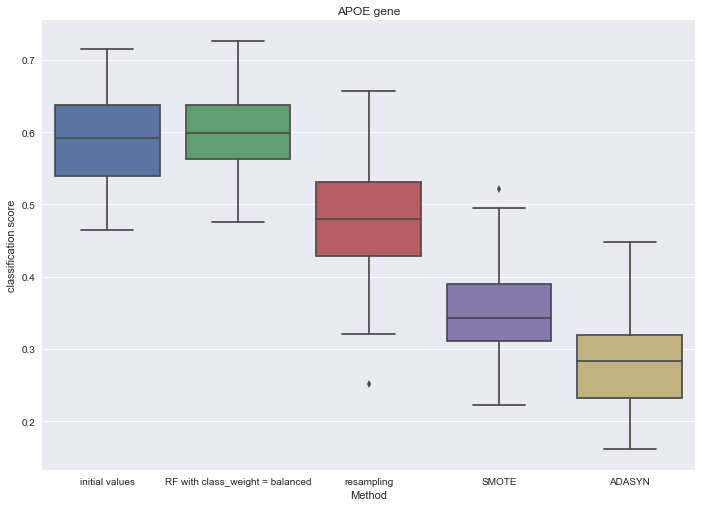

In [23]:
scores = [scores_initial, scores_RF_updated, scores_resampled, scores_smote, scores_adasyn]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(['initial values', 'RF with class_weight = balanced', 'resampling', 'SMOTE', 'ADASYN'], scores)
plt.xlabel('Method')
plt.ylabel('classification score')
plt.title('APOE gene')
plt.savefig('foo.png')
plt.show()

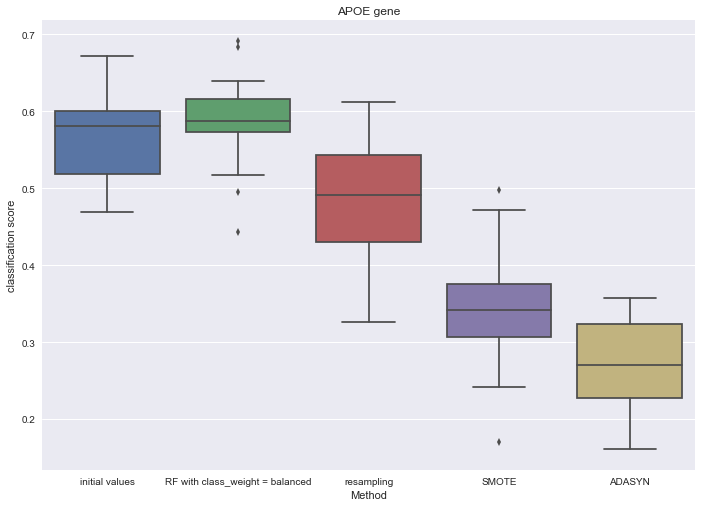

In [104]:
scores = [scores_initial, scores_RF_updated, scores_resampled, scores_smote, scores_adasyn]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(['initial values', 'RF with class_weight = balanced', 'resampling', 'SMOTE', 'ADASYN'], scores)
plt.xlabel('Method')
plt.ylabel('classification score')
plt.title('APOE gene')
plt.savefig('foo1.png')
plt.show()

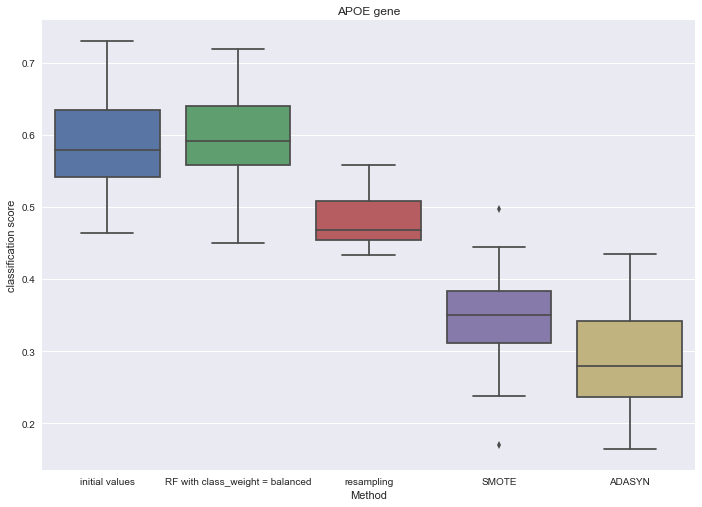

In [106]:
scores = [scores_initial, scores_RF_updated, scores_resampled, scores_smote, scores_adasyn]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(['initial values', 'RF with class_weight = balanced', 'resampling', 'SMOTE', 'ADASYN'], scores)
plt.xlabel('Method')
plt.ylabel('classification score')
plt.title('APOE gene')
plt.savefig('foo2.png')
plt.show()